## Testing the "addition" of FatJets
What does FatJet[i]+FatJet[j] do?
After testing, the conclusion is that it performs a 4-vec addition based on FatJet_mass, _pt, _eta and _phi branches

It returns a four-vector object

In [22]:
import numpy as np
import awkward as ak
import ROOT
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import hist
from hist import Hist

In [3]:
#---------------------------------------------
# Selection cuts
#---------------------------------------------
higgs_mass = 125.
delta_r_cut = 0.8
min_jet_mass = 50.

# FatJet cuts
ptcut = 250.
etacut = 2.5
mass_cut = [100.,150.]
pNet_cut = 0.9105

# Resolved jet cuts
res_ptcut = 30.
res_etacut = 2.5
res_mass_cut = [90.,150.]
# loose cut = 0.0532, med_cut = 0.3040, tight_cut = 0.7476 , https://twiki.cern.ch/twiki/bin/view/CMS/BtagRecommendation106XUL17   
res_deepBcut = 0.0532
#---------------------------------------------


def closest(masses):
    delta = abs(higgs_mass - masses)
    min_delta = ak.min(delta, axis=1)
    is_closest = (delta == min_delta)
    return is_closest


def HbbvsQCD(fatjet):
    score = (fatjet.particleNetMD_Xbb/(fatjet.particleNetMD_Xbb+fatjet.particleNetMD_QCD))
    return score


def precut(fatjets):
    return (fatjets.pt>ptcut) & (np.absolute(fatjets.eta)<etacut)


def FailPassCategories(fatjets, jets=None):
    # sort the fat jets in the descending pNet HbbvsQCD score
    sorted_fatjets = fatjets[ak.argsort(-HbbvsQCD(fatjets),axis=-1)]

    # fail region: 0 fat jets passing the pNet cut
    # pass region: at least 1 fat jets passing the pNet cut
    fail_mask = (HbbvsQCD(sorted_fatjets[:,0])<pNet_cut)
    pass_mask = (HbbvsQCD(sorted_fatjets[:,0])>pNet_cut)
    if jets is not None:
        return fatjets[fail_mask], fatjets[pass_mask], jets[fail_mask], jets[pass_mask]
    else:
        return fatjets[fail_mask], fatjets[pass_mask]


def FatJetMassCut_SR(fatjets):
    return (fatjets.msoftdrop>=mass_cut[0]) & (fatjets.msoftdrop<=mass_cut[1])


def FatJetMassCut_VR_boosted(fatjets):
    return (((fatjets[:,0].msoftdrop<mass_cut[0]) | (fatjets.msoftdrop[:,0]>mass_cut[1])) & (fatjets[:,0].msoftdrop>min_jet_mass) 
    & (fatjets[:,1].msoftdrop>min_jet_mass) & ((fatjets[:,1].msoftdrop<mass_cut[0]) | (fatjets[:,1].msoftdrop>mass_cut[1])) 
    & (fatjets[:,2].msoftdrop>=mass_cut[0]) & (fatjets[:,2].msoftdrop<=mass_cut[1]))


def VR_semiboosted_mask(fatjets):
    return ((fatjets.msoftdrop<mass_cut[0]) | (fatjets.msoftdrop>mass_cut[1])) & (fatjets.msoftdrop>min_jet_mass)

In [4]:
events = NanoEventsFactory.from_root("/STORE/matej/H3_skims/2017/TTbarHadronic/DBADF3D8-7C75-F74B-99AF-7AF0D41083BE.root",schemaclass=NanoAODSchema,metadata={"dataset":""},entry_stop=None).events()

In [5]:
fatjets = events.FatJet
    
# fat jets preselection
fatjets = fatjets[precut(fatjets)]
    
# select events with at least 3 preselected fat jets
fatjets = fatjets[ak.num(fatjets, axis=1)>2]

# apply the SR jet mass cuts to preselected fat jets
fatjets_SR = fatjets
fatjets_SR = fatjets_SR[FatJetMassCut_SR(fatjets_SR)]
#print(len(fatjets_SR))
# apply the VR jet mass cuts to the 3 leading (in pT) fat jets and reject overlaps with the SR
#fatjets = fatjets[FatJetMassCut_VR_boosted(fatjets)]
#print(len(FatJetMassCut_VR_boosted(fatjets)))
#print(len(~(ak.num(fatjets_SR, axis=1)>2)))
fatjets = fatjets[FatJetMassCut_VR_boosted(fatjets) & ~(ak.num(fatjets_SR, axis=1)>2)]
#print(len(fatjets))

# select events with at least 3 good fat jets (at this point this is always true)
fatjets = fatjets[ak.num(fatjets, axis=1)>2]
#print(len(fatjets))

dijet = fatjets[0][0]+fatjets[0][1]
print(fatjets[0][0].mass, fatjets[0][1].mass, dijet.mass)

235.5 185.875 1675.8468329718098


In [6]:
vec1_mass = ROOT.Math.PtEtaPhiMVector(fatjets[0][0].pt,fatjets[0][0].eta,fatjets[0][0].phi,fatjets[0][0].mass)
vec2_mass = ROOT.Math.PtEtaPhiMVector(fatjets[0][1].pt,fatjets[0][1].eta,fatjets[0][1].phi,fatjets[0][1].mass)

vec1_msoftdrop = ROOT.Math.PtEtaPhiMVector(fatjets[0][0].pt,fatjets[0][0].eta,fatjets[0][0].phi,fatjets[0][0].msoftdrop)
vec2_msoftdrop = ROOT.Math.PtEtaPhiMVector(fatjets[0][1].pt,fatjets[0][1].eta,fatjets[0][1].phi,fatjets[0][1].msoftdrop)

dijet_mass = vec1_mass+vec2_mass
dijet_msoftdrop = vec1_msoftdrop+vec2_msoftdrop

#By comparing these values with the output of the previous cell, 
#we conclude that FatJet_mass is used in the 4-vec representation
print(dijet_mass.M(),dijet_msoftdrop.M())


1675.8467860820829 1674.5568193946706


## Testing histograms with weights
Are the stat. uncertainties properly propagated?

In [56]:
fatjet0_pt = fatjets[:,0].pt
weights    = np.full(len(fatjet0_pt),0.5)
binning    = hist.axis.Regular(label="$p_{T}$ [GeV]", name="leading_jet_pt", bins=17, start=400, stop=2000)
#storage="weight" is necessary in order to internally stored (weighted) event counts
h          = Hist(binning,storage="weight")
h_weights  = Hist(binning,storage="weight")
h.fill(fatjet0_pt)
h_weights.fill(fatjet0_pt,weight=weights)

Hist(Regular(17, 400, 2000, name='leading_jet_pt', label='$p_{T}$ [GeV]'), storage=Weight()) # Sum: WeightedSum(value=43, variance=21.5) (WeightedSum(value=49.5, variance=24.75) with flow)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fba214779a0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

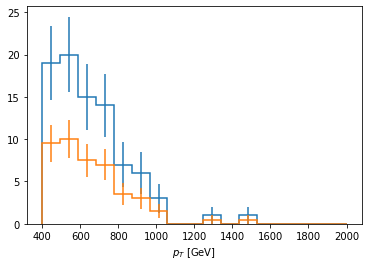

In [39]:
h.plot1d()
h_weights.plot1d()

In [43]:
import uproot

with uproot.recreate("matej_test.root") as fout:
    fout[f"h_orig"] = h
    fout[f"h_weights"] = h_weights

[('h_orig;1', <TH1D (version 3) at 0x7fba213e9f40>), ('h_weights;1', <TH1D (version 3) at 0x7fba213e9730>)]


In [55]:
f          = ROOT.TFile.Open("matej_test.root")
h_orig     = f.Get("h_orig")
h_weights  = f.Get("h_weights")

print("\t\tYield\tErr\tsqrt(yield)")
print("Orig:\t\t{0:.1f}\t{1:.1f}\t{2:.1f}".format(h_orig.GetBinContent(1),h_orig.GetBinError(1),np.sqrt(h_orig.GetBinContent(1))))
print("Weighted:\t{0:.1f}\t{1:.1f}\t{2:.1f}".format(h_weights.GetBinContent(1),h_weights.GetBinError(1),np.sqrt(h_weights.GetBinContent(1))))


		Yield	Err	sqrt(yield)
Orig:		19.0	4.4	4.4
Weighted:	9.5	2.2	3.1


## Conclusion:
When creating a `Hist` object, we need to tell it to track errors with `storage="weight"`.<br> The errors are calculated as a square root of bin counts and properly scaled if the histogram is weighted.<br>This behavior is preserved even when converting `Hist` to ROOT histograms.